In [1]:
import json
import cs_vqe.circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
from utils.molecule_tools import get_molecule#
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
import numpy as np
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD, POWELL, NFT, SPSA, SLSQP, SNOBFIT, COBYLA
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Will store matrices in sparse form


/home/tweaving/.local/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/tweaving/.local/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2O_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET', 'NH_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'B+_STO-3G_SINGLET'])

/home/tweaving/.local/lib/python3.8/site-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1266: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


Number of terms in the ansatz: 8
C_STO-3G_SINGLET reaches chemical accuracy for 4-qubit CS-VQE


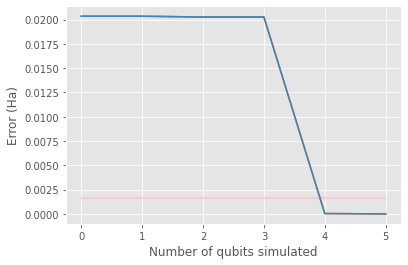

In [3]:
speciesname = "C_STO-3G_SINGLET"
mol_model    = model_data[speciesname]
anz_op = mol_model['ansatze']['uccsd']
mol_circ = cs_circ.cs_vqe_circuit(model_data=mol_model)
num_sim_q = mol_circ.chem_acc_num_q
print('Number of terms in the ansatz:', len(anz_op))
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

# Performing the simulation *without* noise

In [4]:
mol_circ.sufficient_anz_terms(anz_terms=anz_op)

Testing operator 1/8
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 2/8
Testing operator 3/8
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 4/8
Testing operator 5/8
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 6/8
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 7/8
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
Testing operator 8/8
*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...
['IYIXX']
------------------------------------------------------------
Error with 1 operator(s) in Ansatz =  0.0001159309558929067
------------------------------------------------------------


['IYIXX']

In [5]:
#suff_terms=['YXIIIIXX', 'IYIIXIXX', 'XZIIZXYX', 'IIIIXXXY', 'IIIIXZYI'] #LiH
#suff_terms = ['IIYXX', 'IXIYX', 'YIIXX', 'XIIYX', 'IYIXX'] #Be
#suff_terms = ['IXIYX', 'YIIXX'] #B+
suff_terms = ['IYIXX'] #C
#suff_terms = ['YYIIYXII', 'XXIIYZZX', 'YXIIIIYY', 'YXIIIXXI'] #HF
suff_anz_op = {op:anz_op[op] for op in suff_terms}

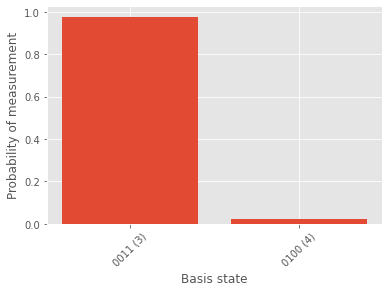

*   Performing 4-qubit CS-VQE over qubit positions 4, 3, 2, 0 ...


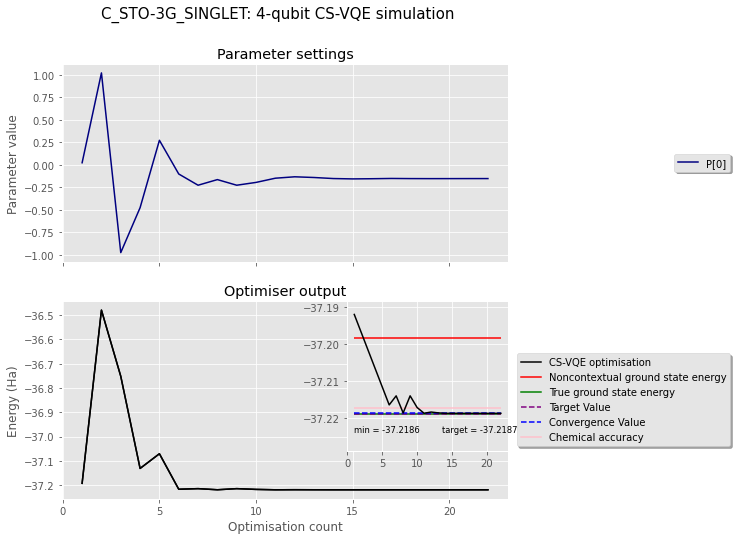

In [6]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=suff_anz_op, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=COBYLA(maxiter=1000), 
                                 param_bound=np.pi,
                                 show_amps=True)

title = '%s: %i-qubit CS-VQE simulation' % (speciesname, num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

In [7]:
#import json 

#data={}
#for k in cs_vqe_results.keys():
#    data[str(k)] = cs_vqe_results[k]
    
#with open("data/IBMQ-runtime/"+speciesname+"/statevectorsim.json", "w") as outfile: 
#    json.dump(data, outfile)

In [8]:
#param_hist = [config for param, config in cs_vqe_results['params'].items()]
#init_params = np.array(list(zip(*param_hist))[-1])

# Performing the simulation *with* noise

The noise model used below emulates IBM's 5-qubit Vigo device, derived from real-life performance data

In [15]:
from qiskit import IBMQ
from utils.circuit_execution_tools import remote_circuit_execution
from matplotlib import pyplot as plt
plt.style.use('ggplot')
with open('data/token.txt', 'r') as file:
    TOKEN = file.read()
IBMQ.save_account(TOKEN, overwrite=True)
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-11-10 16:04:06,361: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [16]:
#data, raw_data = remote_circuit_execution(mol_circ=mol_circ, num_sim_q=num_sim_q, anz_op=anz, maxiter=150, qfi_resamples=150, zero_params=True)

In [17]:
#fig = plot.plot_parameter_settings_alt(data, log_error=True)

In [18]:
provider = IBMQ.get_provider(hub='ibm-q',group='open',project='main')
backends = [b.name() for b in provider.backends() if b.configuration().num_qubits==5]
backends

['ibmq_santiago',
 'ibmq_bogota',
 'ibmq_lima',
 'ibmq_belem',
 'ibmq_quito',
 'ibmq_manila']

In [19]:
ibmq_result = remote_circuit_execution(mol_circ=mol_circ, 
                                       num_sim_q=num_sim_q, 
                                       anz_op=suff_anz_op,
                                       #backend="ibmq_bogota",
                                       maxiter=100, 
                                       qfi_resamples=100,
                                       zero_params=True)

RequestsApiError: '400 Client Error: Bad Request for url: https://runtime-us-east.quantum-computing.ibm.com/jobs. {"errors":[{"code":"bad_request","message":"models.ProgramRunParams.Params: ReadMapCB: expect { or n, but found [, error found in #10 byte of ...|params\\": [\\"{\\\\\\"ansatz|..., bigger context ...|in\\", \\"backend\\": \\"ibmq_qasm_simulator\\", \\"params\\": [\\"{\\\\\\"ansatz\\\\\\": {\\\\\\"__type__\\\\\\": \\\\\\"QuantumCircuit\\\\\\", \\\\|...","more_info":"https://cloud.ibm.com/apidocs/quantum-computing#error-handling"}],"trace":"c65uqvn37kiphhd92erg"}'

In [ ]:
fig=plot.plot_parameter_settings_alt(ibmq_result[0], title=title)